# **Music Recommendation System**

## **Problem Definition**

### **The Context:**
With the advent of technology, societies have become more efficient with their lives. At the sametime, however, individual human lives have also become more fast-paced and distracted, leaving little time to explore artistic pursuits. Also, technology has made significant advancements in the ability to coexist with art and general entertainment. It has in fact made it easier for humans with a shortage of time to find and consume good content.<br>
Almost every internet-based company's revenue relies on the time consumers spend on its platform. These companies need to be able to figure out what kind of content is needed in order to increase customer time spent and make their experience better. Therefore, one of the key challenges for these companies is figuring out what kind of content their customers are most likely to consume.<br>
Spotify is one such audio content provider with a huge market base across the world. With the ever-increasing volume of songs becoming available on the Internet, searching for songs of interest has become a tedious task in itself. However, Spotify has grown significantly in the market because of its ability to recommend the ‘best’ next song to each and every customer based on a huge
preference database gathered over time - millions of customers and billions of songs. This is done by using smart recommendation systems that can recommend songs based on users’ likes/dislikes.

### **The objective:**

The objective is to build a recommendation system to propose the top 10 songs for a user based on the likelihood of listening to those songs.

### **The key questions:**

  * How can we define the user's musical preference ?
  * What factors contribute to a user's musical preference ?
  * What type of recommendation system is best suited for the problem?
  * What ype of system will be best suited to recommend, whatever the profile of the user is, be it a fresh newcomer or someone with a history on the platform ?
  * What features of the songs should be used to make recommendations?
  * How can we evaluate the performance of the recommendation system?
  * How can we ensure that the recommended songs are diverse and not just similar to what the user has already listened to?

Depending on the data available, these questions may reveal different answers. Musical tastes being very personal, recommending new songs to a user is no easy task, and this is what we need to accomplish, as data scientists: build a reliable, accurate, fast and inexpensive recommendation system.

### **The problem formulation**:

For this project, we need to develop a recommendation system that is able to suggest a playlist of the top 10 songs for a user that they will be most likely to listen to, be it a fresh new user or a user who has already used the service. We need to the recommendation system to be able to attract new users and retain users we already have.

## **Data Dictionary**

The core data is the Taste Profile Subset released by the Echo Nest as part of the Million Song Dataset. There are two files in this dataset. The first file contains the details about the song id, titles, release, artist name, and the year of release. The second file contains the user id, song id, and the play count of users.

**song_data**

- song_id - A unique id given to every song
- title - Title of the song
- Release - Name of the released album
- Artist_name - Name of the artist
- year - Year of release

**count_data**

- user _id - A unique id given to the user
- song_id - A unique id given to the song
- play_count - Number of times the song was played

## **Data Source**
http://millionsongdataset.com/

### **Importing Libraries and the Dataset**

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# As the surprise package is incompatible with numpy >= 2.0, we need to
# downgrade numpy to a 1.x compatible version, then install surprise
!pip uninstall -y numpy
!pip install numpy==1.24.3

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 84.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
pymc 5.21.2 requires numpy>=

In [1]:
# Now, we may install the scikit-surprise package
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505224 sha256=a5fb2ec6e684f3175c00d72141194bf7eeddee7e704b5ebb15c46570a8c060e8
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
# os lib, to modify the working directory
import os

# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import pandas as pd
import numpy as np

# Import Matplotlib the Basic library for data visualization
import matplotlib.pyplot as plt

# Import seaborn - Slightly advanced library for data visualization
import seaborn as sns

# Import the required library to compute the cosine similarity between two vectors
from sklearn.metrics.pairwise import cosine_similarity

# Import defaultdict from collections A dictionary output that does not raise a key error
from collections import defaultdict

# Impoort mean_squared_error : a performance metrics in sklearn
from sklearn.metrics import mean_squared_error

# Import LabelEncoding
from sklearn.preprocessing import LabelEncoder


### **Utility classes and functions**

In [3]:
# To help with analyzing, and comparing the different models we will build,
# let's create a utility class with which to store and track the different results
# and metrics for each of the models

class KY_ModelResults():

  from enum import Enum

  """
  Simple utility class used to monitor the results we get from model building,
  hypertuning and predictions.
  """

  # This Enum contains all the possible types of results you could get.
  class ResultType(Enum):
    PRF1 = 1 # RMSE Precision Recall F1 /!\ modify your precision_recall_f1_at_k return tuple to add RMSE, if you want to monitor it as well
    PRED = 2 # Prediction

  def __init__(self) -> None:
      self._result_list = [] # List of dicts containing result info
      self.types = self.ResultType

  def add(self, model_name: str, result_type: ResultType, result_data):
    """
    Add a line to the underlying list of results we want to monitor
    You should not use this method, as it is prone to mistakes in names and types
    model_name: Name of the model. Each model should have a specific unique name. This method DOES NOT ensure there are no duplicates!
    result_type: Value from ResultType Enum
    result_data: the output returned by your prediction or building function.
    """
    self._result_list.append(
        {
            'model_name': model_name,
            'type': result_type,
            'data': result_data
        }
    )

  def add_prf1(self, model_name: str, result_data):
    """
    Add results from your precision_recall_f1_at_k
    model_name: Name of the model. Each model should have a specific unique name. This method DOES NOT ensure there are no duplicates!
    result_data: the output of your precision_recall_f1_at_k function
    """
    self.add(model_name, self.__class__.ResultType.PRF1, result_data)

  def add_pred(self, model_name: str, result_data):
    """
    Add results from prediction
    model_name: Name of the model. Each model should have a specific unique name. This method DOES NOT ensure there are no duplicates!
    result_data: the output of your predict function
    """
    self.add(model_name, self.__class__.ResultType.PRED, result_data)

  def remove(self, model_name: str):
    """
    Remove any result whose model name matches. /!\ No safety check is made /!\
    model_name: Name of the model
    """
    self._result_list = [x for x in self._result_list if x.get('model_name') != model_name]

  def show(self, query=None):
    """
    Show the results stored, in the form of a pandas DataFrame.
    query: A string query to be applied to the resulting dataframe
    """
    return_df = pd.DataFrame(self._result_list)
    return_df.columns = ['Model Name', 'Type', 'Data']

    # Styling
    def style_results(row):
      highlight = 'color: red;'
      default = ''

      if hasattr(row, 'details') and type(getattr(row, 'details') is dict) and row.details['was_impossible']:
        return highlight
      return default

    # If a query was submitted, apply it
    if query:
        return_df = return_df.query(query)

    # Applying style and returning results
    return return_df.style.map(style_results)

In [4]:
# Instantiating the utility class
models_results = KY_ModelResults()

### **Load the dataset**

In [5]:
# Change pwd
os.chdir('/content/drive/MyDrive/ADSP/Capstone/RS')

In [6]:
# Importing the datasets
count_df = pd.read_csv('count_data.csv')
song_df = pd.read_csv('song_data.csv')

### **Understanding the data by viewing a few observations**

In [ ]:
# Display first 10 records of count_df data
count_df.head(10)

,Unnamed: 0,user_id,song_id,play_count
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1
5,5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5
6,6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1
7,7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1
8,8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1
9,9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1


In [ ]:
# Display first 10 records of song_df data
song_df.head(10)

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0
5,SOZVAPQ12A8C13B63C,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",Berwald: Symphonies Nos. 1/2/3/4,David Montgomery,0
6,SOQVRHI12A6D4FB2D7,We Have Got Love,Strictly The Best Vol. 34,Sasha / Turbulence,0
7,SOEYRFT12AB018936C,2 Da Beat Ch'yall,Da Bomb,Kris Kross,1993
8,SOPMIYT12A6D4F851E,Goodbye,Danny Boy,Joseph Locke,0
9,SOJCFMH12A8C13B0C2,Mama_ mama can't you see ?,March to cadence with the US marines,The Sun Harbor's Chorus-Documentary Recordings,0


In [ ]:
(song_df['year'] == 0).sum()/song_df.shape[0]

0.484424

**Observations:**
* Some values for 'year' are equal to 0, which may mean that their release year is unknown or too ancient to be precisely known. This value should be treated as missing.
* As the entries having a value of 0 for the year feature represent 48% of the entries in the song dataset, it is not advisable to simply drop them at this point in the analysis. More insight needs be drawn before we take any action on the question.

### **Let us check the data types and and missing values of each column**

In [ ]:
# Display info of count_df
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   user_id     object
 2   song_id     object
 3   play_count  int64 
dtypes: int64(2), object(2)
memory usage: 61.0+ MB


In [ ]:
# Display info of song_df
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999983 non-null   object
 2   release      999993 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


In [ ]:
# Let's see which songs have no title, and if there is a pattern to be found
song_df[song_df['title'].isnull()]

,song_id,title,release,artist_name,year
64262,SOVICLT12A58A7C4D0,NaN,Of Flies And Men,Milton,0
110154,SOZGJGY12A8159E898,NaN,Frailty,The Duskfall,2002
114672,SOAGRAA12AB018D567,NaN,Puce de luxe,Sébastien Roch,0
229353,SOOAFJX12AB018A028,NaN,Puce de luxe,Sébastien Roch,0
264639,SOLDTFD12AB018AFE6,NaN,Puce de luxe,Sébastien Roch,0
458083,SOAUTVB12AB018AFF0,NaN,Puce de luxe,Sébastien Roch,0
487706,SOPOBWY12A8159E8A9,NaN,Frailty and Source,The Duskfall,2002
557125,SOMPGYE12AB018AFE0,NaN,Puce de luxe,Sébastien Roch,0
578241,SOVHAZH12AB018D5B3,NaN,Puce de luxe,Sébastien Roch,0
652287,SOECGBQ12AB018D582,NaN,Puce de luxe,Sébastien Roch,0


**Observations:**
* **count_df** contains **2,000,000 rows**, and **4 columns**.
* The column named **'Unnamed 0'** contains the original row indexes and is numerical. It **should be dropped**.
* **user_id** and **song_id** are **categorical** in essence, and they have an **object dtype**.
* **play_count** is numerical and is an int (**int64**)

* **song_df** contains **1,000,000 entries**, and **5 columns**.
* **4** of the columns have an **object** dtype, and **1** is numerical (**int64**)
* There are **17 missing values** in the '**title**' column, and **7 missing values** in the '**release**' column.
* Most of the title-less songs are from the same artist, from the same album. Given that these entries account for a very low number of entries in the dataset, we will simply drop them.

In [7]:
# Left merge count_df and song_df on "song_id". Drop duplicates from song_df data simultaneously
df = pd.merge(count_df, song_df.drop_duplicates(['song_id']), how='left',
              on='song_id')
# Drop the column 'Unnamed: 0'
df = df.drop(['Unnamed: 0'], axis=1)

# Drop entries with no title or release value
df.dropna(subset=['title', 'release'], inplace=True)

df.head(10)

,user_id,song_id,play_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,Héroes del Silencio,2007
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1,Paper Gangsta,The Fame Monster,Lady GaGa,2008
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1,Stacked Actors,There Is Nothing Left To Lose,Foo Fighters,1999
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1,Sehr kosmisch,Musik von Harmonia,Harmonia,0
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1,Heaven's gonna burn your eyes,Hôtel Costes 7 by Stéphane Pompougnac,Thievery Corporation feat. Emiliana Torrini,2002


In [39]:
# Let's check how many unique values there are for each categorical column in
# the dataset
cat_cols = df.select_dtypes(['object']).columns.to_list()
cat_uniques_dict = {}
for col in cat_cols:
  cat_uniques_dict[col] = df[col].nunique()
pd.DataFrame(cat_uniques_dict, index=[0])

,user_id,song_id,title,release,artist_name
0,76353,10000,9567,5388,3375


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
play_count,2000000.0,3.045485,6.579720,1.0,1.0,1.0,3.0,2213.0
year,2000000.0,1628.644749,778.728286,0.0,1984.0,2002.0,2007.0,2010.0


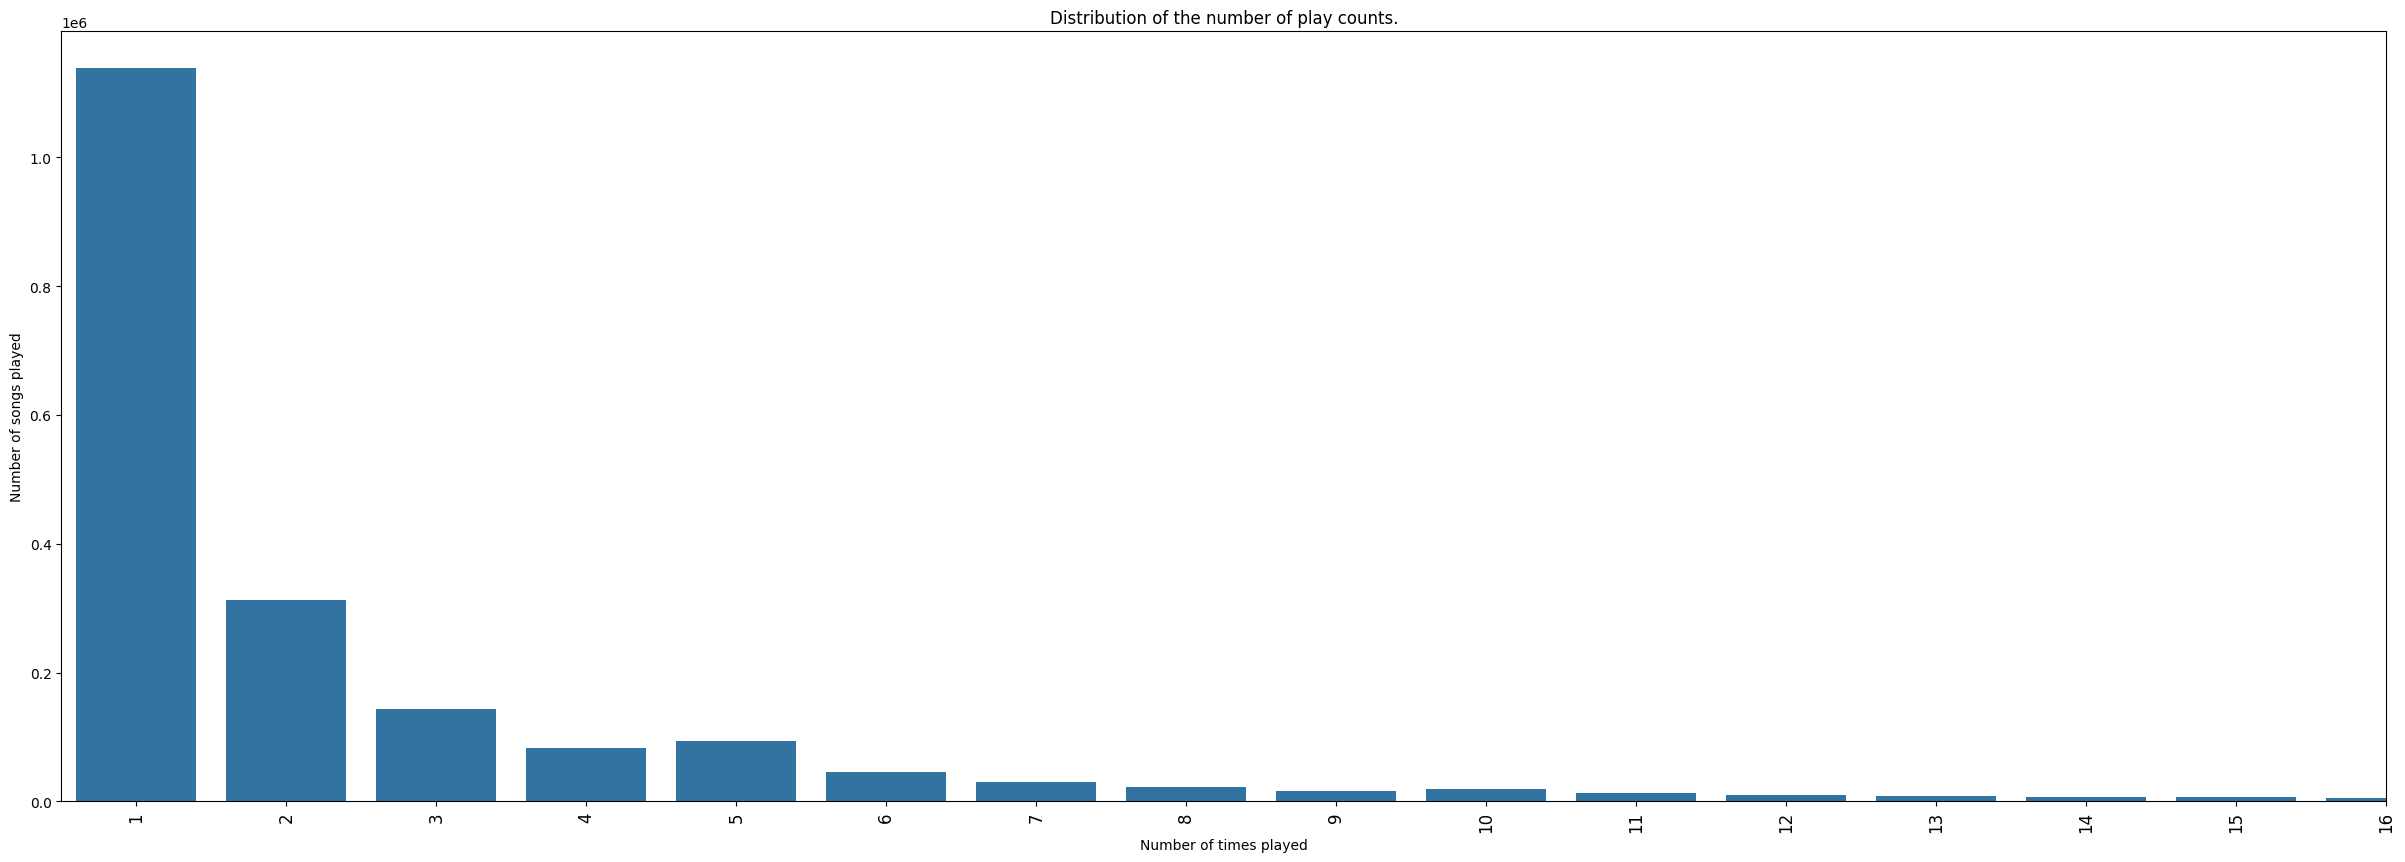

In [ ]:
plt.figure(figsize=(30,10))
dist_count_plot = sns.countplot(x=df['play_count'])
dist_count_plot.set_title('Distribution of the number of play counts.')
dist_count_plot.tick_params(axis="x", rotation=90, labelsize=12)
dist_count_plot.set_xlabel('Number of times played')
dist_count_plot.set_ylabel('Number of songs played')
plt.xlim(None, 15)
plt.show()

In [ ]:
print("Proportion of songs with play_count < 6: ", df['play_count'].value_counts(normalize=True).loc[1:5].sum())

Proportion of songs with play_count < 6:  0.8437725


**Observations:**
* There are **76,353 unique users** in our dataset.
* There are **10,000 unique song ids**, and **9,567 unique song titles**. The discrepancy between the number of unique song ids and unique song titles can be explained by the fact, that different songs by differents artists can have the same title.
* The number of **unique album** and **artist names** are **5,388** and **3,375**, respectively.
* Over **84.37%** of the songs have been **listened to 5 or less times**.

**Think About It:** As the user_id and song_id are encrypted. Can they be encoded to numeric features?<br>
This is going to make handling IDs so much easier, faster and more efficient.

In [8]:
# Apply label encoding for "user_id" and "song_id"
le = LabelEncoder()
df['user_id'] = le.fit_transform(df['user_id'])
df['song_id'] = le.fit_transform(df['song_id'])

In [ ]:
df.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,153,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,413,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,736,1,Stronger,Graduation,Kanye West,2007
3,54961,750,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,1188,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


**Think About It:** As the data also contains users who have listened to very few songs and vice versa, is it required to filter the data so that it contains users who have listened to a good count of songs and vice versa?

A dataset of size 2000000 rows x 7 columns can be quite large and may require a lot of computing resources to process. This can lead to long processing times and can make it difficult to train and evaluate your model efficiently.
In order to address this issue, it may be necessary to trim down your dataset to a more manageable size.

In [9]:
# Get the column containing the users
users = df.user_id

# Create a dictionary that maps users(listeners) to the number of songs that they have listened to
playing_count = dict()

for user in users:
    # If we already have the user, just add 1 to their playing count
    if user in playing_count:
        playing_count[user] += 1

    # Otherwise, set their playing count to 1
    else:
        playing_count[user] = 1

In [10]:
# We want our users to have listened at least 90 songs
SONG_COUNT_CUTOFF = 90

# Create a list of users who need to be removed
remove_users = []

for user, num_songs in playing_count.items():

    if num_songs < SONG_COUNT_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [11]:
# Get the column containing the songs
songs = df.song_id

# Create a dictionary that maps songs to its number of users(listeners)
playing_count = dict()

for song in songs:
    # If we already have the song, just add 1 to their playing count
    if song in playing_count:
        playing_count[song] += 1

    # Otherwise, set their playing count to 1
    else:
        playing_count[song] = 1

In [12]:
# We want our song to be listened by atleast 120 users to be considred
LISTENER_COUNT_CUTOFF = 120

remove_songs = []

for song, num_users in playing_count.items():
    if num_users < LISTENER_COUNT_CUTOFF:
        remove_songs.append(song)

df_final= df.loc[ ~ df.song_id.isin(remove_songs)]

Out of all the songs available, songs with play_count less than or equal to 5 are in almost 90% abundance. So for building the recommendation system let us consider only those songs.

In [13]:
# Keep only records of songs with play_count less than or equal to (<=) 5
df_final = df_final[df_final.play_count<=5]

In [ ]:
# Check the shape of the data
df_final.shape

(117876, 7)

In [ ]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,117876.0,37986.496954,22041.887894,11.0,19275.0,37049.0,57152.0,76347.0
song_id,117876.0,4896.602608,2916.276544,21.0,2220.0,5023.0,7522.0,9989.0
play_count,117876.0,1.700058,1.089517,1.0,1.0,1.0,2.0,5.0
year,117876.0,1652.819683,761.726035,0.0,1994.0,2005.0,2008.0,2010.0


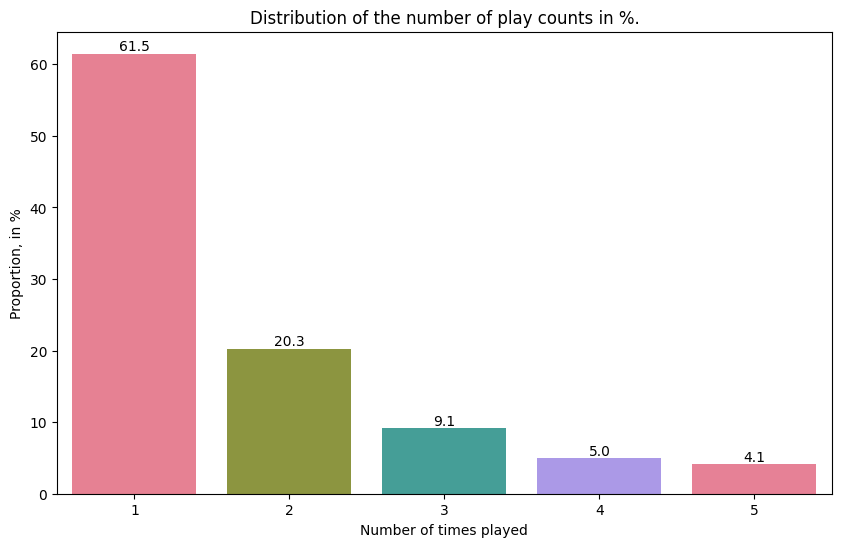

In [ ]:
# Creating a plot fot the distribution of play_counts
plt.figure(figsize=(10,6)) # Setting figure size
trim_dist_count_plot = sns.countplot(x=df_final['play_count'],
                                     hue=df_final['play_count'], stat="percent",
                                     legend=False, palette='husl')
# Setting the title, the bar labels, and the axis labels
trim_dist_count_plot.set_title(
    'Distribution of the number of play counts in %.')
trim_dist_count_plot.set_xlabel('Number of times played')
trim_dist_count_plot.set_ylabel('Proportion, in %')

for i in trim_dist_count_plot.containers:
  trim_dist_count_plot.bar_label(i, fmt='%.1f')

plt.show()

**Observations:**
* After trimming down the dataset to retain only the users who have listened to at least 90 songs, and the songs that have been listened by at least 120 users, we have decided to only retain those songs that have been listened to 5 or less times to work with, as they account for almost 90%.
* 17% of the entries were interactions with songs whose release date was 0. This situation may affect our simulations, as it implies all these songs have a common feature, year, which is not necessarily true. To avoid affecting our models with such a bias, those entries have been dropped. Another solution would have been to retrieve the "missing dates" throgh the use of web scraping with the help of Requests and BeuatifulSoup4, but a lack of time and resources to do so guided our decision to finally simply drop the problematic entries.
* The large majority of **play_counts are set between 1 and 3** (**90.9%**)
* The data is clearly biased towards the lower play counts, which implies we will need to have a low threshold for our evaluations of precision@k and recall@k.

## **Exploratory Data Analysis**

### **Let's check the total number of unique users, songs, artists in the data**

Total number of unique user id

In [ ]:
# Display total number of unique user_id
df_final['user_id'].nunique()

3155

Total number of unique song id

In [ ]:
# Display total number of unique song_id
df_final['song_id'].nunique()

563

Total number of unique artists

In [ ]:
# Display total number of unique artists
df_final['artist_name'].nunique()

232

**Observations and Insights:**
* In the final dataset we will be using to build our recommender system models, there are **3,155 unique user** ids, **563 unique song** ids, and **232 unique artist** names.
* Given the number of unique users and unique songs, there is a possibility of 3,155 * 563 = **1,776,265** interactions, but we "only" have **117,876**, which means the data is **sparse**.


### **Let's find out about the most interacted songs and interacted users**

Most interacted songs

In [ ]:
df_final['song_id'].value_counts()

,count
song_id,
8582,751
352,748
2220,713
1118,662
4152,652
...,...
9048,103
6450,102
990,101


Most interacted users

In [ ]:
df_final['user_id'].value_counts()

,count
user_id,
61472,243
15733,227
37049,202
9570,184
23337,177
...,...
19776,1
45476,1
17961,1


**Observations and Insights:**
* From our df_final, the **most interacted** song is **song_id 8582** with **751 interactions**, and the **most interacted** user is **user_id 61472** with **207 interactions**.


Songs released on yearly basis

In [20]:
song_play_count_by_year = pd.DataFrame(df.query('year != 0').groupby('year')['play_count'].sum())

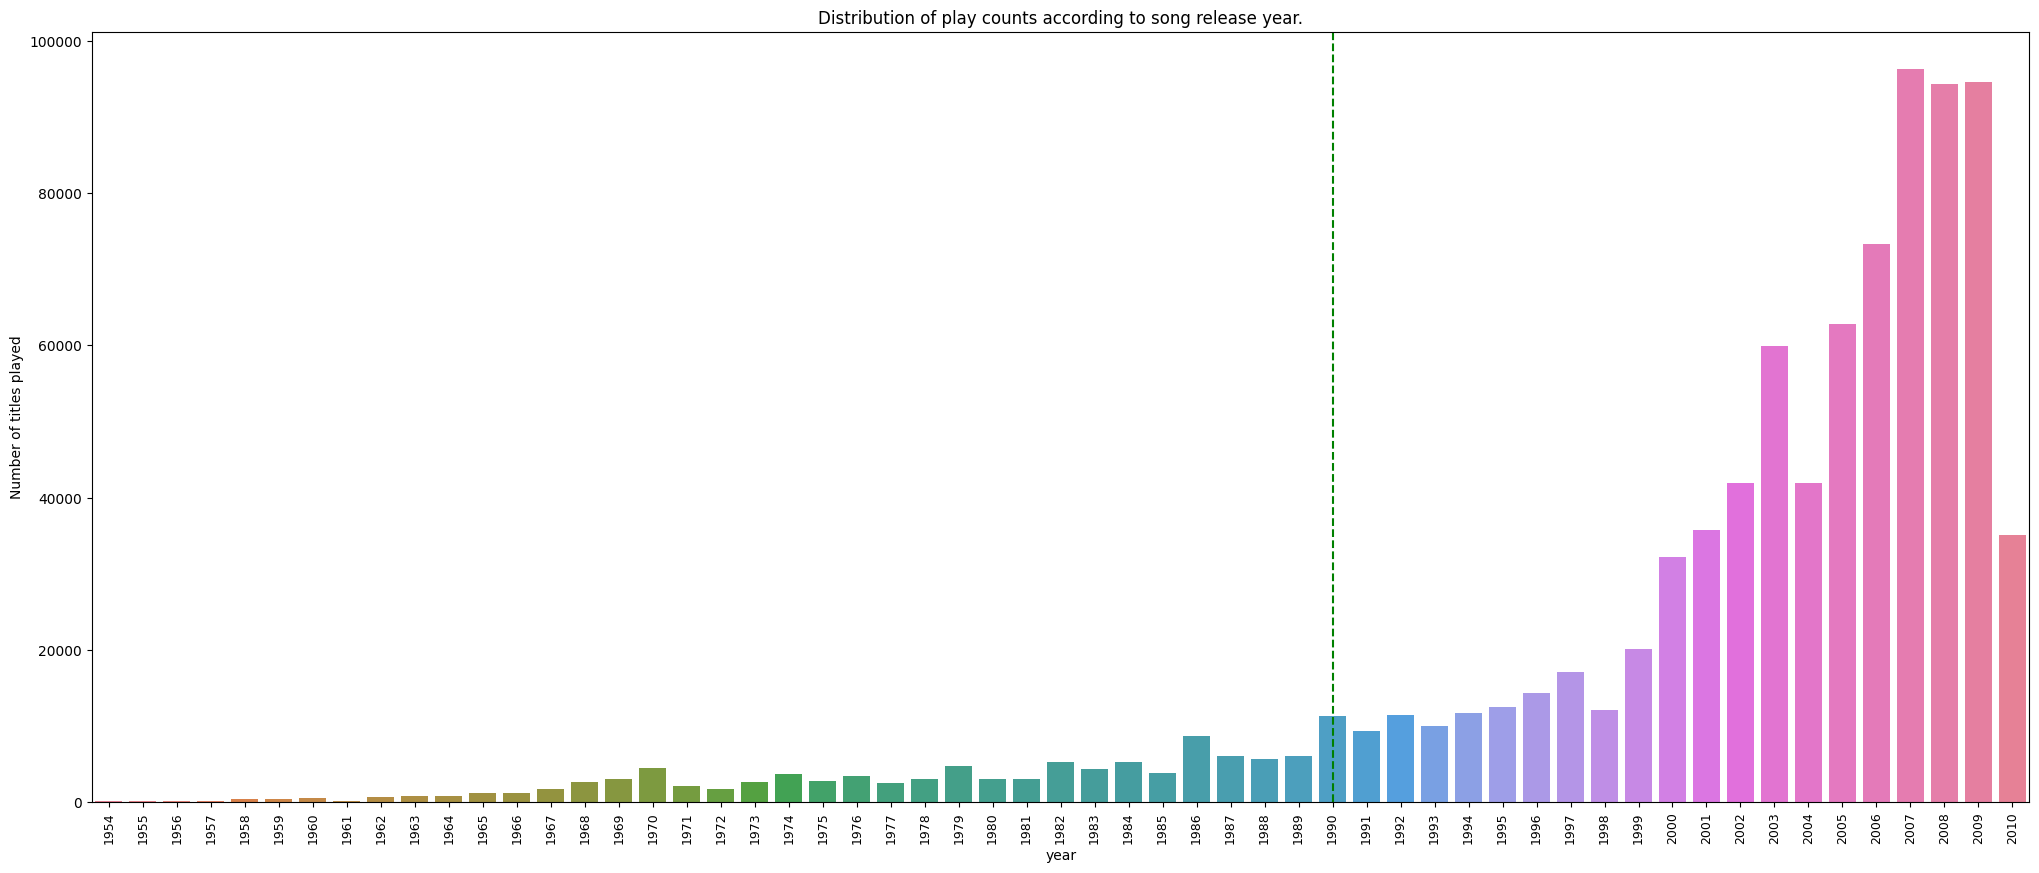

In [21]:
plt.figure(figsize=(25,10))
play_count_per_year_plot = sns.barplot(data=song_play_count_by_year,
                                       x=song_play_count_by_year.index,
                                       y='play_count', estimator=np.median,
                                       hue=song_play_count_by_year.index,
                                       legend=False, palette='husl', )
# Change orientation of the x-axis ticks to allow for easy reading
play_count_per_year_plot.tick_params(axis='x', rotation=90, labelsize=9)
# Set the x label of the plot
play_count_per_year_plot.set_xlabel('year')

# Set title
play_count_per_year_plot.set_title('Distribution of play counts according to song release year.')
plt.axvline(x=song_play_count_by_year.index.tolist().index(1990), color='g', ls='--')

# Set the y label of the plot
play_count_per_year_plot.set_ylabel('Number of titles played');

In [15]:
# Find out the number of songs released in a year, use the songs_df
  # Hint: Use groupby function on the 'year' column
songs_count = pd.DataFrame(song_df.groupby('year').count()['title'])
songs_count = songs_count.drop(songs_count.index[0])
songs_count.head()

,title
year,
1922,6
1924,5
1925,7
1926,19
1927,43


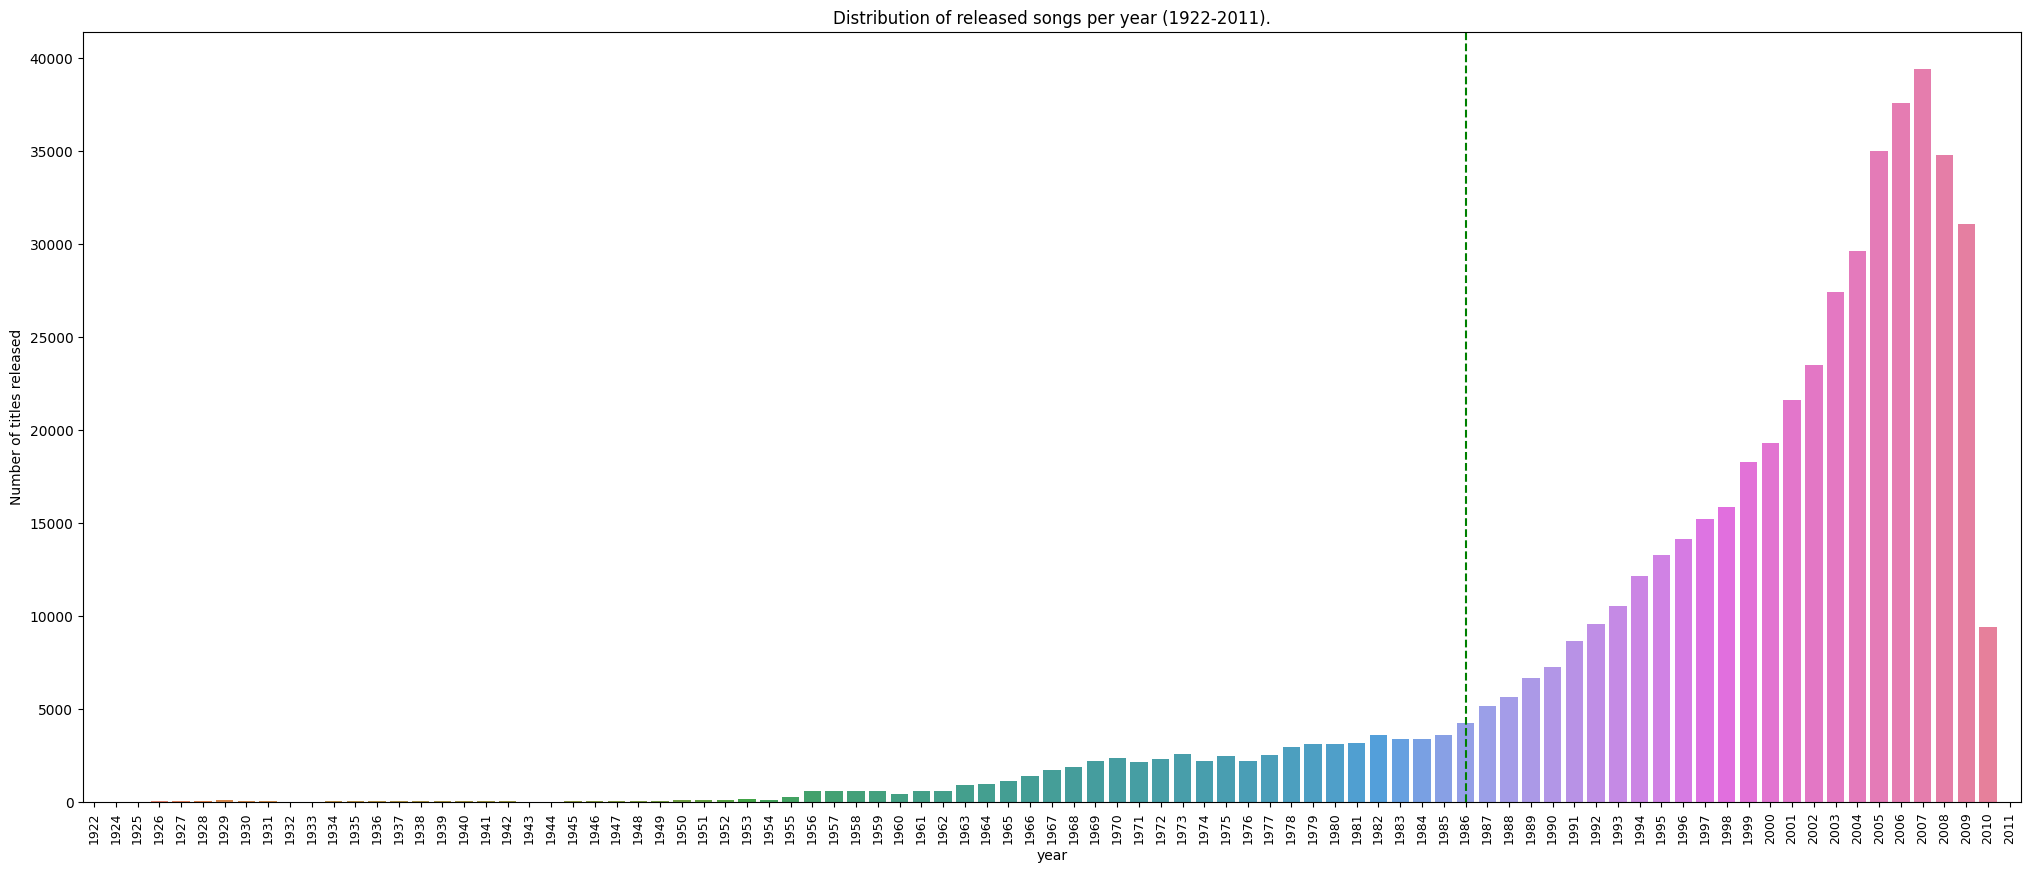

In [17]:
# Create a barplot plot with y label as "number of titles played" and x -axis year

# Set the figure size
plt.figure(figsize=(25,10))
song_per_year_plot = sns.barplot(data=songs_count, x=songs_count.index,
                                  y='title', estimator=np.median,
                                 hue=songs_count.index, legend=False,
                                 palette='husl')
# Change orientation of the x-axis ticks to allow for easy reading
song_per_year_plot.tick_params(axis='x', rotation=90, labelsize=9)
# Set the x label of the plot
song_per_year_plot.set_xlabel('year')

# Set title
song_per_year_plot.set_title('Distribution of released songs per year (1922-2011).')
plt.axvline(x=songs_count.index.tolist().index(1986), color='g', ls='--')

# Set the y label of the plot
song_per_year_plot.set_ylabel('Number of titles released');

# Show the plot

**Observations and Insights:**
* The distribution of the number of titles released by year is left-skewed, with a significant increase in the number of titles released from year 1986 on (we can see the slope getting steeper from 1986).
* Years 2005, 2006, 2007, and 2008 are the top 4 highest in song release.
* The distribution of played songs by year of release is also left-skewed, with a significant increase in number of songs played from year 1990 on.
* Songs from 1922 to 1953 (included) are never played
* Songs from the years 1922 to 1955 are shown to be almost never played.
* There is a sudden drop in songs released in years 2010 and 2011 (with almost none in 2011).
* This drop can also be observed concerning play counts by release year.

**Think About It:** What other insights can be drawn using exploratory data analysis?

Now that we have explored the data, let's apply different algorithms to build recommendation systems.

**Note:** Use the shorter version of the data, i.e., the data after the cutoffs as used in Milestone 1.

## Building various models

### **Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems based on the sum of play counts.

In [ ]:
# Calculating average play_count
       # Hint: Use groupby function on the song_id column
average_count = df_final.groupby('song_id')['play_count'].mean()

# Calculating the frequency a song is played
      # Hint: Use groupby function on the song_id column
play_freq = df_final.groupby('song_id')['play_count'].count() # Weird to call it a frequency

In [ ]:
# Making a dataframe with the average_count and play_freq
final_play = pd.DataFrame({'avg_count': average_count, 'play_freq': play_freq})
# Let us see the first five records of the final_play dataset
final_play.head()

,avg_count,play_freq
song_id,,
21,1.622642,265
22,1.492424,132
52,1.729216,421
62,1.728070,114
93,1.452174,115


In [ ]:
# Let's get some statistical info about final_play
final_play.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_count,563.0,1.652936,0.217654,1.23871,1.492805,1.626761,1.765858,3.373832
play_freq,563.0,209.371226,117.576729,96.00000,129.000000,160.000000,247.000000,751.000000


Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [ ]:
# Build the function to find top n songs
def top_n_songs(data, n, min_interaction=100, debug=False):
  # First, find the songs with minimum number of interactions
  recommendations = data[data['play_freq'] >= min_interaction]
  # Sort values according to avg_count in descending order.
  recommendations = recommendations.sort_values(by='avg_count', ascending=False)

  if debug:
    print("Max avg: ", recommendations.avg_count.max())
    print(recommendations.head(n))

  return recommendations.head(n).index.to_list()

In [ ]:
# Recommend top 10 songs using the function defined above
print()
top_n_songs(final_play, 10)

[7224, 6450, 9942, 5531, 5653, 8483, 2220, 657, 614, 352]

### **User User Similarity-Based Collaborative Filtering**

To build the user-user-similarity-based and subsequent models we will use the "surprise" library.

In [ ]:
# Install the surprise package using pip. Uncomment and run the below code to do the same

# !pip install surprise

# Surprise hase been installed already

In [ ]:
# Import necessary libraries

# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing play_counts, data should be in structure - user; item; play_count
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms import SVD

# For implementing KFold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise.prediction_algorithms import CoClustering


### Some useful functions

Below is the function to calculate precision@k and recall@k, RMSE, and F1_Score@k to evaluate the model performance.

**Think About It:** Which metric should be used for this problem to compare different models?
We will use RMSE and F_ score to evaluate our models' performance.

In [ ]:
def precision_recall_at_k(model, k=30, threshold=1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    #Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, playing_count in user_est_true.items():

        # Sort play count by estimated value
        playing_count.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in playing_count)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in playing_count[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in playing_count[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    #Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)),3)
    #Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)),3)

    accuracy.rmse(predictions)
    print('Precision: ', precision) #Command to print the overall precision
    print('Recall: ', recall) #Command to print the overall recall
    f1_score = round((2*precision*recall)/(precision+recall),3) # Formula to compute the F-1 score.
    print('F_1 score: ', f1_score)
    return accuracy.rmse(predictions, verbose=False), precision, recall, f1_score

**Think About It:** In the function precision_recall_at_k above the threshold value used is 1.5. How precision and recall are affected by changing the threshold? What is the intuition behind using the threshold value of 1.5?
The threshold value is the value at which an item is condidered to be relevant.<br>
A first intuition would be to set it a little lower than the mean value for our target feature, here play_count. Our play_count mean is ~1.68, so a threshold value of 1.50 seems a sensible choice.<br>
Setting the threshold value lower would certainly bring our performance metrics up, but the lower we get, the more we have a risk of overfitting:<br>
If we were to lower our threshold to 1.0, we would most certainly attain very high scores in precision, recall and F_1 score, but this would actually make any song with a play_count of 1 relevant no matter their differences.

Below we are loading the **dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`** which is required by this library. To do this we will be **using the classes `Reader` and `Dataset`**

You will also notice here that we read the dataset by providing a scale of ratings. However, as you would know, we do not have ratings data of the songs. In this case, we are going to use play_count as a proxy for ratings with the assumption that the more the user listens to a song, the higher the chance that they like the song

In [ ]:
# Instantiating Reader scale with expected rating scale
 #use rating scale (0, 5)
reader = Reader(rating_scale=(0, 5))

# Loading the dataset
 # Take only "user_id","song_id", and "play_count"
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']],
                            reader)

# Splitting the data into train and test dataset
 # Take test_size = 0.4, random_state = 42
trainset, testset = train_test_split(data, test_size=0.4, random_state=42)

**Think About It:** How changing the test size would change the results and outputs?

In [ ]:
# Build the default user-user-similarity model
sim_options = {
    'name': 'cosine',
    'user_based': True
}

# KNN algorithm is used to find desired similar items
 # Use random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 30
 # Use sim_user_user model
models_results.add_prf1('sim_user_user',precision_recall_at_k(sim_user_user))

RMSE: 1.0878
Precision:  0.396
Recall:  0.692
F_1 score:  0.504


**Observations and Insights:**
* In our model, we want to **minimize both false positives and false negatives**, so we want to **maximize our F_1 score**.
* On our baseline user-user similarity based model, RMSE is 1.0878: This is how far the overall predicted play_count are from the actual value. The lower the RMSE, the better.
* **Precision** is **0.396**, which means out of all recommended songs, **39.6%** are **relevant**.
* **Recall** is **0.692**, which means that, out of all relevant songs, **69.2%** are **recommended**.
* The **F_1 score** is **0.504**, meaning that **a short majority of recommended songs are relevant and relevant songs were recommended to users**.
* The metrics are quite low on our baseline model, so we'll try to improve them by performing hyperparameter tuning on the model.

In [ ]:
# Let's get three sample users to try our predictions.
# First, let's find a song with some interactions. The threshold will be set as the median average play count
from random import choice, sample
random_song = choice(final_play[final_play['avg_count'] >= final_play['avg_count'].median()].index)
random_song

4954

In [ ]:
# Let's define a function to pick a song, according to a user having listened to it or not
def pick_song(user_id, interaction=False):
  """
  Pick a song, according to it having been listened to by a user or not

  Parameters
  ----------
  user_id: a valid user_id
  interaction: whether the song is to have already been listened to by user or not (Boolean, defaults to False)
  """
  filter_mask = df_final['user_id'] == user_id # Mask filtering entries with user_id
  song_id_list = df_final[filter_mask] if interaction else df_final[~filter_mask] # filtered DF
  return choice(song_id_list['song_id'].values) # Return one random song_id from the filtered DF

In [ ]:
# Let's pick a random user who has interacted with our random song, and two others who have not
# Let's first define a utility function
def pick_random_users(song_id, nb_not_interacted=2, verbose=True):
  """
  Randomly pick a sample user who has interacted with a song, and x users who have not

  Parameters
  ----------
  song_id: a song id that exists in the dataset
  nb_not_interacted: the number of users who have not interacted with the song, that we want returned
  verbose: print the results before returning them. Default: True

  Returns
  -------
  tuple
    A tuple containing two more tuples in the shape of:
    (reference_user, reference_user_play_count) , (not_interacted_users)
  """
  filter_mask = df_final['song_id'] == song_id # Create a mask to retrieve entries with song_id
  reference_user = choice(df_final[filter_mask]['user_id'].values) # Pick a random user_id from the filtered DF containing users who have interacted with song_id
  reference_mark = df_final[(df_final['user_id'] == reference_user) & filter_mask]['play_count'].values[0] # Retrieve our reference_user's play_count for song_id
  not_interacted_users = sample(list(df_final[~filter_mask]['user_id'].values), k=nb_not_interacted) # Retrieve x unique user_id who have NOT interacted with song_id

  if verbose:
    print('Reference user: ', reference_user)
    print('Play count:', reference_mark )
    print('Not interacted users:', not_interacted_users)

  return ((reference_user, reference_mark), tuple(not_interacted_users))

In [ ]:
# Now, let's pick our random users. This is for the sake of showcasing an acceptable way of picking random sample users.
# The users picked in the final verison of the notebook may be different, as the cells will be executed several different times, leading to varying values.
sample_users = pick_random_users(random_song)

Reference user:  68613
Play count: 3
Not interacted users: [48298, 38989]


**To be noted**:
* On the first successful run of the pick_random_users() function, the **song_id** fed to the function was **4954**.
* The **reference user** (the one who has listened to the song) who was randomly picked was user_id **68613**, with a **play count of 3**.
* The **two users** who have not listened to the song that were randomly picked were users **48298**, and **38989**.
* This was done to showcase how random users and items could be picked programmatically. It is, however, very impractical in the case of this project, where we need to give observations after each prediction, and where the user and item to test have been chosen at some point by the creator of the notebook. Therefore, we will not use the results from these functions to test our models, except on the very first baseline model.

In [ ]:
# Predicting play_count for a sample user with a listened song
# Use any user id  and song_id
models_results.add_pred('sim_user_user', sim_user_user.predict(
    sample_users[0][0], random_song, r_ui=sample_users[0][1], verbose=True
))

user: 68613      item: 4954       r_ui = 3.00   est = 2.15   {'actual_k': 40, 'was_impossible': False}


In [ ]:
# Predicting play_count for a sample user with a song not-listened by the user
 #predict play_count for any sample user
models_results.add_pred('sim_user_user', sim_user_user.predict(
    sample_users[1][0], random_song, verbose=True
))

user: 48298      item: 4954       r_ui = None   est = 2.08   {'actual_k': 40, 'was_impossible': False}


In [ ]:
# Because we are asked to use user_id 6958 with song_id 1671 (r_ui=2) afterwards, let's predict for this user and this song
models_results.add_pred('sim_user_user', sim_user_user.predict(
    6958, 1671, r_ui=2, verbose=True
))

user: 6958       item: 1671       r_ui = 2.00   est = 1.80   {'actual_k': 40, 'was_impossible': False}


In [ ]:
# Let's pick a random sample song user 6958 has never listened to
pick_song(6958)

6189

In [ ]:
# Let's predict for user 6958 and an unlistened song
models_results.add_pred('sim_user_user', sim_user_user.predict(
    6958, 6189, verbose=True
))

user: 6958       item: 6189       r_ui = None   est = 1.75   {'actual_k': 40, 'was_impossible': False}


In [ ]:
# As we're asked to use song_id 3232 later, let's predict for user 6958 and an song 3232
models_results.add_pred('sim_user_user', sim_user_user.predict(
    6958, 3232, verbose=True
))

user: 6958       item: 3232       r_ui = None   est = 1.64   {'actual_k': 40, 'was_impossible': False}


In [ ]:
models_results.show()

,Model Name,Type,Data
0,sim_user_user,ResultType.PRF1,"(1.0878229431949291, 0.396, 0.692, 0.504)"
1,sim_user_user,ResultType.PRED,"user: 68613 item: 4954 r_ui = 3.00 est = 2.15 {'actual_k': 40, 'was_impossible': False}"
2,sim_user_user,ResultType.PRED,"user: 48298 item: 4954 r_ui = None est = 2.08 {'actual_k': 40, 'was_impossible': False}"
3,sim_user_user,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.80 {'actual_k': 40, 'was_impossible': False}"
4,sim_user_user,ResultType.PRED,"user: 6958 item: 6189 r_ui = None est = 1.75 {'actual_k': 40, 'was_impossible': False}"
5,sim_user_user,ResultType.PRED,"user: 6958 item: 3232 r_ui = None est = 1.64 {'actual_k': 40, 'was_impossible': False}"


**Observations and Insights:**
* For the 6958-1671 user-item pair, the predicted play_count is **1.80** when the actual play_count is **2**. In this case, the prediction is **not far from the actual value**, and as **play_count** can only actually be a **whole number**, we would **round** this estimated value to **2**, which matches the actual value.
* For user 6958 and song 3232, the predicted value is 1.64. This would make song 3232 relevant for user 6958.
* For the 68613-4954 user-item pair, the predicted play_count is 2.15, when the actual value is 3. Here again, our model predicts that the song would be relevant for this user, although the predicted value is a little low.
* This model needs improvement.

Now, let's try to tune the model and see if we can improve the model performance.

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'], # Let's test all similiraty metrics
        'user_based': [True],
        'min_support': [2, 4]
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
suu_gs = GridSearchCV(KNNBasic, param_grid=param_grid, measures=['rmse'], cv=3,
                      n_jobs=-1)

# Fitting the data
 # Use entire data for GridSearch
suu_gs.fit(data)

# Best RMSE score
print(suu_gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(suu_gs.best_params['rmse'])

1.0456974436990132
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}


In [ ]:
# Train the best model found in above gridsearch
sim_user_user_optimized = KNNBasic(**suu_gs.best_params['rmse'],
                                   random_state=1, verbose=False)
sim_user_user_optimized.fit(trainset)
models_results.add_prf1('sim_user_user_optimized',
                        precision_recall_at_k(sim_user_user_optimized))

RMSE: 1.0521
Precision:  0.413
Recall:  0.721
F_1 score:  0.525


In [ ]:
#models_results.show()[models_results.show()['Type'] == models_results.ResultType.PRF1]
models_results.show('Type == @models_results.types.PRF1')

,Model Name,Type,Data
0,sim_user_user,ResultType.PRF1,"(1.0878229431949291, 0.396, 0.692, 0.504)"
6,sim_user_user_optimized,ResultType.PRF1,"(1.0520740288297823, 0.413, 0.721, 0.525)"


**Observations and Insights:**
* The overall metrics for the optimized model have slightly improved: RMSE has gotten lower (~1.052), precision (0.413), recall (0.721), and the F_1 score (0.525) have gotten slightly higher, meaning the model has improved.

In [ ]:
# Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui = 2
models_results.add_pred('sim_user_user_optimized',
                        sim_user_user_optimized.predict(6958, 1671, r_ui=2,
                                                verbose=True))

user: 6958       item: 1671       r_ui = 2.00   est = 1.96   {'actual_k': 24, 'was_impossible': False}


In [ ]:
# Predict the play count for a song that is not listened to by the user (with user_id 6958)
models_results.add_pred('sim_user_user_optimized',
                        sim_user_user_optimized.predict(6958, 1756, verbose=True))

user: 6958       item: 1756       r_ui = None   est = 1.77   {'actual_k': 28, 'was_impossible': False}


In [ ]:
# Predict the play count for a song that is not listened (3232) to by the user (with user_id 6958)
models_results.add_pred('sim_user_user_optimized',
                        sim_user_user_optimized.predict(6958, 3232, verbose=True))

user: 6958       item: 3232       r_ui = None   est = 1.45   {'actual_k': 10, 'was_impossible': False}


In [ ]:
models_results.show('Type == @models_results.types.PRED')

,Model Name,Type,Data
1,sim_user_user,ResultType.PRED,"user: 68613 item: 4954 r_ui = 3.00 est = 2.15 {'actual_k': 40, 'was_impossible': False}"
2,sim_user_user,ResultType.PRED,"user: 48298 item: 4954 r_ui = None est = 2.08 {'actual_k': 40, 'was_impossible': False}"
3,sim_user_user,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.80 {'actual_k': 40, 'was_impossible': False}"
4,sim_user_user,ResultType.PRED,"user: 6958 item: 6189 r_ui = None est = 1.75 {'actual_k': 40, 'was_impossible': False}"
5,sim_user_user,ResultType.PRED,"user: 6958 item: 3232 r_ui = None est = 1.64 {'actual_k': 40, 'was_impossible': False}"
7,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.96 {'actual_k': 24, 'was_impossible': False}"
8,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 1756 r_ui = None est = 1.77 {'actual_k': 28, 'was_impossible': False}"
9,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 3232 r_ui = None est = 1.45 {'actual_k': 10, 'was_impossible': False}"


**Observations and Insights:**
* The prediction for the user-item pair (user: 6958, song: 1671) returned an estimated play count of 1.96, when the actual value was 2.
* This prediction is closer to the actual value than the baseline model was. The prediction on this sample user-item pair has improved.

**Think About It:** Along with making predictions on listened and unknown songs can we get 5 nearest neighbors (most similar) to a certain song?
* To be able to do this, we would need to use an item-item similarity based model.
* As the two models we have built so far are **user-user similarity based models**, we could only find the **nearest neighbors** to a certain **user**.

In [ ]:
# Use inner id 0
sim_user_user_optimized.get_neighbors(0, 5)

[42, 1131, 17, 186, 249]

In [ ]:
# Now, let's try and fin the 5 nearest neighbors to (raw) user_id 6958
print("List of the 5 nearest users to user_id 6958 (in the form raw_id (inner_id)): ")
[f'{sim_user_user_optimized.trainset.to_raw_uid(inner_user)} ({inner_user})' for inner_user in sim_user_user_optimized.get_neighbors(
      sim_user_user_optimized.trainset.to_inner_uid(6958), 5)]

List of the 5 nearest users to user_id 6958 (in the form raw_id (inner_id)): 


['36010 (1355)', '48175 (1667)', '31451 (200)', '32108 (408)', '47165 (948)']

In [ ]:
pd.merge(df_final[df_final['user_id'] == 6958], df_final[df_final['user_id'] == 36010], on='artist_name', how='inner')

,user_id_x,song_id_x,play_count_x,title_x,release_x,artist_name,year_x,user_id_y,song_id_y,play_count_y,title_y,release_y,year_y
0,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,36010,961,2,Love In 2 Parts,Distillation,2000
1,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,36010,1180,1,Monday Morning Cold (band),Monday Morning Cold,0
2,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,36010,1480,1,Fast As I Can,Monday Morning Cold,2000
3,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,36010,1756,1,You Mustn't Kick It Around,Distillation,2000
4,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,36010,3360,1,Lullaby In Three/Four,Monday Morning Cold,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,6958,9065,1,Balloons (Single version),Balloons,Foals,2007,36010,8599,1,The French Open,Antidotes,2007
141,6958,9351,2,The Police And The Private,Live It Out,Metric,2005,36010,1050,5,Wet Blanket,Old World Underground_ Where Are You Now?,2003
142,6958,9351,2,The Police And The Private,Live It Out,Metric,2005,36010,1455,1,Grow Up and Blow Away,Grow Up and Blow Away,2001
143,6958,9351,2,The Police And The Private,Live It Out,Metric,2005,36010,1752,1,Gimme Sympathy,Gimme Sympathy,2009


**Observations**:
* To have a sense of the nearest neighbors being actually close to the user, we had an inner join on artist name between original user and one of its neighbors, in order to make sure they do share common likes. With 145 entries in common, we can say that, indeed, they have some common tastes.

Below we will be implementing a function where the input parameters are:

- data: A **song** dataset
- user_id: A user-id **against which we want the recommendations**
- top_n: The **number of songs we want to recommend**
- algo: The algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

  # Creating an empty list to store the recommended song ids
  #recommendations = []

  # Creating an user item interactions matrix
  user_item_interaction_matrix = data.pivot(
      index='user_id', columns='song_id', values='play_count')

  # Extracting those song ids which the user_id has not played yet
  not_interacted_songs = user_item_interaction_matrix.loc[user_id][user_item_interaction_matrix.loc[user_id].isnull()].index.tolist()

  # Looping through each of the song ids which user_id has not interacted yet


        # Predicting the users for those non played song ids by this user


        # Appending the predicted play_counts

  # In an effort to make the code a little faster and more efficient, I chose to use a list comprehension instead of using a for loop
  # The code is shorter and remains easily readable, as the list comprehension is very simple
  recommendations = [(item_id, algo.predict(user_id, item_id).est) for item_id in not_interacted_songs]

  # Sorting the predicted play_counts in descending order
  recommendations.sort(key=lambda x: x[1], reverse=True)


  return recommendations[:top_n] # Returing top n highest predicted play_count songs for this user

In [ ]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine
suu_recommendations = get_recommendations(df_final, 6958, 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pd.DataFrame(suu_recommendations, columns=['song_id', 'predicted_play_count'])

,song_id,predicted_play_count
0,5531,2.553335
1,317,2.518269
2,4954,2.406776
3,8635,2.396606
4,5943,2.390723


In [ ]:
for song_id in suu_recommendations:
  print(df_final[df_final['song_id'] == song_id[0]][['title', 'artist_name']].values[0])

['Secrets' 'OneRepublic']
['Undo' 'Björk']
['The Maestro' 'Beastie Boys']
['Una Confusion' 'LU']
["You've Got The Love" 'Florence + The Machine']


**Observations and Insights:**
* The above DataFrame shows the top  5 recommendations for user_id 6958, using the optimized user-user similarity-based recommendation engine.

### Correcting the play_counts and Ranking the above songs

In [ ]:
def ranking_songs(recommendations, playing_count):
  # Sort the songs based on play counts
  ranked_songs = playing_count.loc[[items[0] for items in recommendations]].sort_values(
      'play_freq', ascending=False
  )[['play_freq']].reset_index()

  # Merge with the recommended songs to get predicted play_counts
  ranked_songs = ranked_songs.merge(
      pd.DataFrame(
          recommendations, columns=['song_id', 'predicted_play_count']
          ), on='song_id', how='inner')

  # Rank the songs based on corrected play_counts
  ranked_songs['corrected_play_count'] = ranked_songs['predicted_play_count'] - 1 / np.sqrt(ranked_songs['play_freq'])

  # Sort the songs based on corrected play_counts
  ranked_songs = ranked_songs.sort_values('corrected_play_count', ascending=False)

  return ranked_songs

**Think About It:** In the above function to correct the predicted play_count a quantity 1/np.sqrt(n) is subtracted. What is the intuition behind it? Is it also possible to add this quantity instead of subtracting?

In [ ]:
# Applying the ranking_songs function on the final_play data
ranking_songs(suu_recommendations, final_play)

,song_id,play_freq,predicted_play_count,corrected_play_count
0,5531,618,2.553335,2.513109
2,317,411,2.518269,2.468943
1,5943,423,2.390723,2.342101
3,4954,183,2.406776,2.332854
4,8635,155,2.396606,2.316284


**Observations and Insights:**
* In the above-corrected rating formula, we could add the quantity 1 / np.sqrt(n) instead of subtracting it to get more optimistic predictions. But here we are subtracting this quantity, as there are some songs with play_count 5 and we can't have a play_count more than 5 for a song (at least on our training and testing data, as the scale we've chosen has a max limmit of 5), as we have chosen to limit play counts to 5, in order to be able to use this feature as ou rating scale.
* While comparing the play_count of two songs, it is not only the play_counts that describe the likelihood of the user to that song. Along with the play_count, the number of users who have played that song also becomes important to consider. Due to this, we have calculated the "corrected_play_count" for each song. Commonly, the higher the "play_count" of a song, the more it is liked by users. To interpret the above concept, a song played 7 times by 4 people is less liked in comparison to a song played 6 times by 100 people

### Item Item Similarity-based collaborative filtering recommendation systems

In [ ]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance
sim_options = {
    'name': 'cosine',
    'user_based': False
}

# KNN algorithm is used to find desired similar items
 # Use random_state = 1
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 30
 # Use sim_user_user model
models_results.add_prf1('sim_item_item',precision_recall_at_k(sim_item_item))

RMSE: 1.0394
Precision:  0.307
Recall:  0.562
F_1 score:  0.397


In [ ]:
models_results.show("Type == @models_results.types.PRF1")

,Model Name,Type,Data
0,sim_user_user,ResultType.PRF1,"(1.0878229431949291, 0.396, 0.692, 0.504)"
6,sim_user_user_optimized,ResultType.PRF1,"(1.0520740288297823, 0.413, 0.721, 0.525)"
10,sim_item_item,ResultType.PRF1,"(1.0393632434634457, 0.307, 0.562, 0.397)"


**Observations and Insights:**
* RMSE is better on this baseline model than it is on the previous one.
* All metrics of our baseline model are lower in comparison to the user-user similarity-based baseline model.
* Specifically, the F_1 score is very low (0.397), in comparison with the previous models.
* We will try to improve this by using GridSearchCV.


In [ ]:
# Predicting play count for a sample user_id 6958 and song (with song_id 1671) listened to by the user
models_results.add_pred('sim_item_item', sim_item_item.predict(
    6958, 1671, r_ui=2, verbose=True
))

user: 6958       item: 1671       r_ui = 2.00   est = 1.36   {'actual_k': 20, 'was_impossible': False}


In [ ]:
# Predict the play count for a user that has not listened to the song (with song_id 1671)
models_results.add_pred('sim_item_item', sim_item_item.predict(
    21937, 1671, verbose=True))

user: 21937      item: 1671       r_ui = None   est = 1.84   {'actual_k': 40, 'was_impossible': False}


**Observations and Insights:**
* The predicted play_count for user_id 6958 is lower than with the baseline user-user similarity-based collaborative filtering model.
* When predicting play_count for a user (user_id 21937) who has not listened to song 1671, th predicted play_count is 1.84

In [ ]:
# Apply grid search for enhancing model performance
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
        'user_based': [False],
        'min_support': [2, 4]
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
sii_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
sii_gs.fit(data)

# Find the best RMSE score
print(sii_gs.best_score['rmse'])

# Extract the combination of parameters that gave the best RMSE score
print(sii_gs.best_params['rmse'])

1.0248197204635152
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'min_support': 2}}


**Think About It:** How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html).

In [ ]:
# Apply the best model found in the grid search
sim_options = {
    'name': 'pearson_baseline',
    'user_based': False,
    'min_support': 2
}

sim_item_item_optimized = KNNBasic(**sii_gs.best_params['rmse'],
                                   random_state=1, verbose=False)

#Training on the trainset
sim_item_item_optimized.fit(trainset)

# Computing precision@k, recall@k and f_1@k with k=30 and threshold=1.5
models_results.add_prf1('sim_item_item_optimized',
                        precision_recall_at_k(sim_item_item_optimized))

RMSE: 1.0328
Precision:  0.408
Recall:  0.665
F_1 score:  0.506


In [ ]:
models_results.show('Type == @models_results.types.PRF1')

,Model Name,Type,Data
0,sim_user_user,ResultType.PRF1,"(1.0878229431949291, 0.396, 0.692, 0.504)"
6,sim_user_user_optimized,ResultType.PRF1,"(1.0520740288297823, 0.413, 0.721, 0.525)"
10,sim_item_item,ResultType.PRF1,"(1.0393632434634457, 0.307, 0.562, 0.397)"
13,sim_item_item_optimized,ResultType.PRF1,"(1.0328499949256782, 0.408, 0.665, 0.506)"


**Observations and Insights:**
* After tuning hyperparameters, the **F_1 score is getting much better** when compared to that of the baseline model, **going from 0.397 to 0.506**.
* The RMSE is getting slightly better on the optimized model.

In [ ]:
# Predict the play_count by a user(user_id 6958) for the song (song_id 1671)
models_results.add_pred('sim_item_item_optimized',
                        sim_item_item_optimized.predict(
                            6958, 1671, r_ui=2, verbose=True
                        ))

user: 6958       item: 1671       r_ui = 2.00   est = 1.96   {'actual_k': 10, 'was_impossible': False}


In [ ]:
# Predicting play count for a sample user_id 6958 with song_id 3232 which is not listened to by the user
models_results.add_pred('sim_item_item_optimized',
                        sim_item_item_optimized.predict(
                            6958, 3232, verbose=True
                        ))

user: 6958       item: 3232       r_ui = None   est = 1.28   {'actual_k': 10, 'was_impossible': False}


In [ ]:
models_results.show()

,Model Name,Type,Data
0,sim_user_user,ResultType.PRF1,"(1.0878229431949291, 0.396, 0.692, 0.504)"
1,sim_user_user,ResultType.PRED,"user: 68613 item: 4954 r_ui = 3.00 est = 2.15 {'actual_k': 40, 'was_impossible': False}"
2,sim_user_user,ResultType.PRED,"user: 48298 item: 4954 r_ui = None est = 2.08 {'actual_k': 40, 'was_impossible': False}"
3,sim_user_user,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.80 {'actual_k': 40, 'was_impossible': False}"
4,sim_user_user,ResultType.PRED,"user: 6958 item: 6189 r_ui = None est = 1.75 {'actual_k': 40, 'was_impossible': False}"
5,sim_user_user,ResultType.PRED,"user: 6958 item: 3232 r_ui = None est = 1.64 {'actual_k': 40, 'was_impossible': False}"
6,sim_user_user_optimized,ResultType.PRF1,"(1.0520740288297823, 0.413, 0.721, 0.525)"
7,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.96 {'actual_k': 24, 'was_impossible': False}"
8,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 1756 r_ui = None est = 1.77 {'actual_k': 28, 'was_impossible': False}"
9,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 3232 r_ui = None est = 1.45 {'actual_k': 10, 'was_impossible': False}"


**Observations and Insights:**
* For user_id 6958 and item 1671, the estimated play_count is 1.96 when the actual value is 2, which is equivalent to the prediction given by the optimized user-user similarity-based collaborative model, the difference being in the number of nearest neigbors found an used.
* The prediction for user_id 6958 and song_id 3232 estimates a play_count of 1.28, which is lower than what was predecited with the optimized user-user similarity-based collaborative model.

In [ ]:
# Find five most similar items to the item with inner id 0
sim_item_item_optimized.get_neighbors(0, 5)

[124, 523, 173, 205, 65]

In [ ]:
# Now, let's try and find the 5 nearest neighbors to (raw) item_id 1671
print("List of the 5 nearest songs to song_id 1671 (in the form raw_id (inner_id)): ")
[f'{sim_item_item_optimized.trainset.to_raw_iid(inner_item)} ({inner_item})' for inner_item in sim_item_item_optimized.get_neighbors(
      sim_item_item_optimized.trainset.to_inner_iid(1671), 5)]

List of the 5 nearest songs to song_id 1671 (in the form raw_id (inner_id)): 


['3380 (559)', '9767 (360)', '5385 (276)', '1994 (140)', '154 (173)']

In [ ]:
pd.merge(df_final[df_final['song_id'] == 1671], df_final[df_final['song_id'] == 3380], on='artist_name', how='inner')

,user_id_x,song_id_x,play_count_x,title_x,release_x,artist_name,year_x,user_id_y,song_id_y,play_count_y,title_y,release_y,year_y
0,6958,1671,2,Sleeping In (Album),Give Up,Postal Service,2003,69587,3380,1,Brand New Colony (Album),Give Up,2003
1,6958,1671,2,Sleeping In (Album),Give Up,Postal Service,2003,51415,3380,1,Brand New Colony (Album),Give Up,2003
2,6958,1671,2,Sleeping In (Album),Give Up,Postal Service,2003,74334,3380,1,Brand New Colony (Album),Give Up,2003
3,6958,1671,2,Sleeping In (Album),Give Up,Postal Service,2003,15700,3380,2,Brand New Colony (Album),Give Up,2003
4,6958,1671,2,Sleeping In (Album),Give Up,Postal Service,2003,47806,3380,1,Brand New Colony (Album),Give Up,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23695,10807,1671,2,Sleeping In (Album),Give Up,Postal Service,2003,24740,3380,2,Brand New Colony (Album),Give Up,2003
23696,10807,1671,2,Sleeping In (Album),Give Up,Postal Service,2003,35114,3380,1,Brand New Colony (Album),Give Up,2003
23697,10807,1671,2,Sleeping In (Album),Give Up,Postal Service,2003,10807,3380,2,Brand New Colony (Album),Give Up,2003
23698,10807,1671,2,Sleeping In (Album),Give Up,Postal Service,2003,6919,3380,1,Brand New Colony (Album),Give Up,2003


**Observatrions**:
* In the list of nearest neighbors for song_id 1671, the first one to come out is song_id 3380
* When comparing song_id 1671 and song_id 3380, thanks to an inner join on artist_name, we can see that the two songs have common points, meaning that the model actually works.

In [ ]:
# Making top 5 recommendations for any user_id  with item_item_similarity-based recommendation engine
sii_recommendations = get_recommendations(df_final, 6958, 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pd.DataFrame(sii_recommendations, columns=['song_id', 'predicted_play_count'])

,song_id,predicted_play_count
0,2342,2.653903
1,5101,2.386577
2,139,2.313727
3,7519,2.270864
4,8099,2.212702


In [ ]:
for song_id in sii_recommendations:
  print(df_final[df_final['song_id'] == song_id[0]][['title', 'artist_name']].values[0])

['Alaska' 'Camera Obscura']
['White Sky' 'Vampire Weekend']
['I Got Mine' 'The Black Keys']
['A Dustland Fairytale' 'The Killers']
['Toxic' 'Britney Spears']


In [ ]:
# Applying the ranking_songs function
ranking_songs(sii_recommendations, final_play)

,song_id,play_freq,predicted_play_count,corrected_play_count
4,2342,111,2.653903,2.558987
2,5101,130,2.386577,2.298871
3,139,119,2.313727,2.222057
1,7519,168,2.270864,2.193712
0,8099,275,2.212702,2.152399


**Observations and Insights:**

* In the above-corrected rating formula, we could add the quantity 1 / np.sqrt(n) instead of subtracting it to get more optimistic predictions. But here we are subtracting this quantity, as there are some songs with play_count 5 and we can't have a play_count more than 5 for a song (at least on our training and testing data, as the scale we've chosen has a max limmit of 5), as we have chosen to limit play counts to 5, in order to be able to use this feature as ou rating scale.
* While comparing the play_count of two songs, it is not only the play_counts that describe the likelihood of the user to that song. Along with the play_count, the number of users who have played that song also becomes important to consider. Due to this, we have calculated the "corrected_play_count" for each song. Commonly, the higher the "play_count" of a song, the more it is liked by users. To interpret the above concept, a song played 7 times by 4 people is less liked in comparison to a song played 6 times by 100 people
* The model works and is able to recommend songs comparable to song_id 1671.


### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

In [ ]:
# Build baseline model using svd
svd = SVD(random_state=1)

# Training on the trainset
svd.fit(trainset)

# Let's compute the precision@k and recall@k
models_results.add_prf1('svd', precision_recall_at_k(svd))

RMSE: 1.0252
Precision:  0.41
Recall:  0.633
F_1 score:  0.498


In [ ]:
models_results.show('Type == @models_results.types.PRF1')

,Model Name,Type,Data
0,sim_user_user,ResultType.PRF1,"(1.0878229431949291, 0.396, 0.692, 0.504)"
6,sim_user_user_optimized,ResultType.PRF1,"(1.0520740288297823, 0.413, 0.721, 0.525)"
10,sim_item_item,ResultType.PRF1,"(1.0393632434634457, 0.307, 0.562, 0.397)"
13,sim_item_item_optimized,ResultType.PRF1,"(1.0328499949256782, 0.408, 0.665, 0.506)"
16,svd,ResultType.PRF1,"(1.0252486830347507, 0.41, 0.633, 0.498)"


**Observations:**
* The baseline SVD model achieves the lowest RMSE out of all previous models.
* It has a better F_1 score thant the baseline item-item similarity-based collaborative model, but its F_1 score is lower than that of the baseline user-user similarity-based collaborative model.
* We will try to improve it with hyperparameter tuning.

In [ ]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2
models_results.add_pred('svd', svd.predict(
    6958, 1671, r_ui=2, verbose=True
))

user: 6958       item: 1671       r_ui = 2.00   est = 1.27   {'was_impossible': False}


In [ ]:
# Making a prediction for the user who has not listened to the song (song_id 3232)
models_results.add_pred('svd', svd.predict(
    6958, 3232, verbose=True
))

user: 6958       item: 3232       r_ui = None   est = 1.56   {'was_impossible': False}


In [ ]:
models_results.show('Type == @models_results.types.PRED and not `Model Name`.str.contains("optimized")')

,Model Name,Type,Data
1,sim_user_user,ResultType.PRED,"user: 68613 item: 4954 r_ui = 3.00 est = 2.15 {'actual_k': 40, 'was_impossible': False}"
2,sim_user_user,ResultType.PRED,"user: 48298 item: 4954 r_ui = None est = 2.08 {'actual_k': 40, 'was_impossible': False}"
3,sim_user_user,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.80 {'actual_k': 40, 'was_impossible': False}"
4,sim_user_user,ResultType.PRED,"user: 6958 item: 6189 r_ui = None est = 1.75 {'actual_k': 40, 'was_impossible': False}"
5,sim_user_user,ResultType.PRED,"user: 6958 item: 3232 r_ui = None est = 1.64 {'actual_k': 40, 'was_impossible': False}"
11,sim_item_item,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.36 {'actual_k': 20, 'was_impossible': False}"
12,sim_item_item,ResultType.PRED,"user: 21937 item: 1671 r_ui = None est = 1.84 {'actual_k': 40, 'was_impossible': False}"
17,svd,ResultType.PRED,user: 6958 item: 1671 r_ui = 2.00 est = 1.27 {'was_impossible': False}
18,svd,ResultType.PRED,user: 6958 item: 3232 r_ui = None est = 1.56 {'was_impossible': False}


**Observations**:
* The model predicts an **estimated play_count of 1.27** when the actual value is **2**. This estimated value is the further off out of all the previous baseline models for this user-item pair.
* With this model, the song would not be considered relevant for user the user. We have, here, a False Negative for a threshold of 1.5.
*It looks like the baseline VSD model underestimates the the play_count.

#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In [ ]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20, 30],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}

# Perform 3-fold grid-search cross-validation
svd_gs = GridSearchCV(SVD, param_grid=param_grid, measures=['rmse'], cv=3,
                      n_jobs=-1)

# Fitting data
svd_gs.fit(data)

# Best RMSE score
print(svd_gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])


1.0123317402532825
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).<br><br>
It would be possible to try and improve the performance of the model further by tuning other hyperparameters, like particular learning rates, for example, in order to try and have a finer-grained hypertuning. This is definitely something to be tried later, when we have more time and more computational resources available.

In [ ]:
# Building the optimized SVD model using optimal hyperparameters
svd_optimized = SVD(**svd_gs.best_params['rmse'], random_state=1)

# Training on the trainset
svd_optimized.fit(trainset)

# Computing precision@k and recall@k
models_results.add_prf1('svd_optimized', precision_recall_at_k(svd_optimized))

RMSE: 1.0141
Precision:  0.415
Recall:  0.635
F_1 score:  0.502


In [ ]:
models_results.show('Type == @models_results.ResultType.PRF1')

,Model Name,Type,Data
0,sim_user_user,ResultType.PRF1,"(1.0878229431949291, 0.396, 0.692, 0.504)"
6,sim_user_user_optimized,ResultType.PRF1,"(1.0520740288297823, 0.413, 0.721, 0.525)"
10,sim_item_item,ResultType.PRF1,"(1.0393632434634457, 0.307, 0.562, 0.397)"
13,sim_item_item_optimized,ResultType.PRF1,"(1.0328499949256782, 0.408, 0.665, 0.506)"
16,svd,ResultType.PRF1,"(1.0252486830347507, 0.41, 0.633, 0.498)"
19,svd_optimized,ResultType.PRF1,"(1.0141335474580673, 0.415, 0.635, 0.502)"


**Observations and Insights:**
* After hyperparameter tuning, the RMSE has decreased, the precision, recall and f_1 score have increased, meaning that the model has improved.
* This model remains under the previous optimized models when it comes to F_1 score.

In [ ]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671
models_results.add_pred('svd_optimized', svd_optimized.predict(
    6958, 1671, r_ui=2, verbose=True
))

user: 6958       item: 1671       r_ui = 2.00   est = 1.34   {'was_impossible': False}


In [ ]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline play_count
models_results.add_pred('svd_optimized', svd_optimized.predict(
    6958, 3232, verbose=True
))

user: 6958       item: 3232       r_ui = None   est = 1.44   {'was_impossible': False}


In [ ]:
models_results.show('Type == @models_results.ResultType.PRED and `Model Name`.str.contains("_optimized")')

,Model Name,Type,Data
7,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.96 {'actual_k': 24, 'was_impossible': False}"
8,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 1756 r_ui = None est = 1.77 {'actual_k': 28, 'was_impossible': False}"
9,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 3232 r_ui = None est = 1.45 {'actual_k': 10, 'was_impossible': False}"
14,sim_item_item_optimized,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.96 {'actual_k': 10, 'was_impossible': False}"
15,sim_item_item_optimized,ResultType.PRED,"user: 6958 item: 3232 r_ui = None est = 1.28 {'actual_k': 10, 'was_impossible': False}"
20,svd_optimized,ResultType.PRED,user: 6958 item: 1671 r_ui = 2.00 est = 1.34 {'was_impossible': False}
21,svd_optimized,ResultType.PRED,user: 6958 item: 3232 r_ui = None est = 1.44 {'was_impossible': False}


**Observations and Insights:**
* The estimated play_count given by the optimized SVD model is 1.34, which is fairly far from the actual play_count of 2.
* If we were to round the estimated value, we would obtain a value of 1, which is too far from the actual value.
* It is the lowest estimation given by an optimized model, so far.

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final, 6958, 5, svd_optimized)

In [ ]:
for song_id in svd_recommendations:
  print(df_final[df_final['song_id'] == song_id[0]][['title', 'artist_name']].values[0])

['Victoria (LP Version)' "Old 97's"]
['Transparency' 'White Denim']
['The Big Gundown' 'The Prodigy']
['Brave The Elements' 'Colossal']
['Greece 2000' 'Three Drives']


In [ ]:
# Ranking songs based on above recommendations
ranking_songs(svd_recommendations, final_play)

,song_id,play_freq,predicted_play_count,corrected_play_count
2,7224,107,2.601899,2.505225
1,5653,108,2.108728,2.012502
4,8324,96,2.014091,1.912029
0,9942,150,1.940115,1.858465
3,6450,102,1.952493,1.853478


**Observations and Insights:**
* The table above shows the top 5 recommendations with corrected_play_count using svd_optimized.
* Each recommended song has a play_freq inferior to 200.

### Cluster Based Recommendation System

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

In [ ]:
# Make baseline clustering model
clust_baseline = CoClustering(random_state=1)

# Training the algorithm on the trainset
clust_baseline.fit(trainset)

# Computing precision@k and recall@k with k = 10
models_results.add_prf1('clust', precision_recall_at_k(clust_baseline))

RMSE: 1.0487
Precision:  0.397
Recall:  0.582
F_1 score:  0.472


In [ ]:
models_results.show('Type == @models_results.types.PRF1 and not `Model Name`.str.contains("_optimized")')

,Model Name,Type,Data
0,sim_user_user,ResultType.PRF1,"(1.0878229431949291, 0.396, 0.692, 0.504)"
10,sim_item_item,ResultType.PRF1,"(1.0393632434634457, 0.307, 0.562, 0.397)"
16,svd,ResultType.PRF1,"(1.0252486830347507, 0.41, 0.633, 0.498)"
22,clust,ResultType.PRF1,"(1.0486672859827517, 0.397, 0.582, 0.472)"


In [ ]:
# Making prediction for user_id 6958 and song_id 1671
models_results.add_pred('clust', clust_baseline.predict(
    6958, 1671, r_ui=2, verbose=True
))

user: 6958       item: 1671       r_ui = 2.00   est = 1.29   {'was_impossible': False}


In [ ]:
# Making prediction for user (userid 6958) for a song(song_id 3232) not listened to by the user
models_results.add_pred('clust', clust_baseline.predict(
    6958, 3232, verbose=True
))

user: 6958       item: 3232       r_ui = None   est = 1.48   {'was_impossible': False}


**Observations:**
* The estimated play_count is 1.29 when the actual value is 2.
* The prediction falls far from the actual value.

#### Improving clustering-based recommendation system by tuning its hyper-parameters

In [ ]:
# Set the parameter space to tune
param_grid = {
    'n_cltr_u': [3, 4, 5, 6, 7, 8, 9],
    'n_cltr_i': [3, 4, 5, 6, 7, 8, 9],
    'n_epochs': [10, 20, 30]
    }

# Performing 3-fold grid search cross-validation
clust_gs = GridSearchCV(CoClustering, param_grid=param_grid, measures=['rmse'],
                        cv=3, n_jobs=-1)

# Fitting data
clust_gs.fit(data)

# Best RMSE score
print(clust_gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(clust_gs.best_params['rmse'])


1.0447667988894933
{'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 10}


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/co_clustering.html).

In [ ]:
# Train the tuned Coclustering algorithm
clust_optimized = CoClustering(**clust_gs.best_params['rmse'],
                               random_state=1)

# Training the algorithm on the trainset
clust_optimized.fit(trainset)

# Computing precision@k and recall@k with k = 10
models_results.add_prf1('clust_optimized',
                        precision_recall_at_k(clust_optimized))

RMSE: 1.0487
Precision:  0.397
Recall:  0.582
F_1 score:  0.472


In [ ]:
models_results.show('Type == @models_results.types.PRF1')

,Model Name,Type,Data
0,sim_user_user,ResultType.PRF1,"(1.0878229431949291, 0.396, 0.692, 0.504)"
6,sim_user_user_optimized,ResultType.PRF1,"(1.0520740288297823, 0.413, 0.721, 0.525)"
10,sim_item_item,ResultType.PRF1,"(1.0393632434634457, 0.307, 0.562, 0.397)"
13,sim_item_item_optimized,ResultType.PRF1,"(1.0328499949256782, 0.408, 0.665, 0.506)"
16,svd,ResultType.PRF1,"(1.0252486830347507, 0.41, 0.633, 0.498)"
19,svd_optimized,ResultType.PRF1,"(1.0141335474580673, 0.415, 0.635, 0.502)"
22,clust,ResultType.PRF1,"(1.0486672859827517, 0.397, 0.582, 0.472)"
25,clust_optimized,ResultType.PRF1,"(1.0487110943002285, 0.397, 0.582, 0.472)"


**Observations and Insights:**
* None of the performance metrics have changed. The model has not improved.

In [ ]:
# Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671
# The estimated play_count should be the same as with the baseline model, as no change could be seen
models_results.add_pred('clust_optimized', clust_optimized.predict(
    6958, 1671, r_ui=2, verbose=True
))

user: 6958       item: 1671       r_ui = 2.00   est = 1.31   {'was_impossible': False}


In [ ]:
# Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline play_count
models_results.add_pred('clust_optimized', clust_optimized.predict(
    6958, 3232, verbose=True
))

user: 6958       item: 3232       r_ui = None   est = 1.49   {'was_impossible': False}


In [ ]:
models_results.show('Type == @models_results.types.PRED')

,Model Name,Type,Data
1,sim_user_user,ResultType.PRED,"user: 68613 item: 4954 r_ui = 3.00 est = 2.15 {'actual_k': 40, 'was_impossible': False}"
2,sim_user_user,ResultType.PRED,"user: 48298 item: 4954 r_ui = None est = 2.08 {'actual_k': 40, 'was_impossible': False}"
3,sim_user_user,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.80 {'actual_k': 40, 'was_impossible': False}"
4,sim_user_user,ResultType.PRED,"user: 6958 item: 6189 r_ui = None est = 1.75 {'actual_k': 40, 'was_impossible': False}"
5,sim_user_user,ResultType.PRED,"user: 6958 item: 3232 r_ui = None est = 1.64 {'actual_k': 40, 'was_impossible': False}"
7,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.96 {'actual_k': 24, 'was_impossible': False}"
8,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 1756 r_ui = None est = 1.77 {'actual_k': 28, 'was_impossible': False}"
9,sim_user_user_optimized,ResultType.PRED,"user: 6958 item: 3232 r_ui = None est = 1.45 {'actual_k': 10, 'was_impossible': False}"
11,sim_item_item,ResultType.PRED,"user: 6958 item: 1671 r_ui = 2.00 est = 1.36 {'actual_k': 20, 'was_impossible': False}"
12,sim_item_item,ResultType.PRED,"user: 21937 item: 1671 r_ui = None est = 1.84 {'actual_k': 40, 'was_impossible': False}"


**Observations and Insights:**
* There is no difference between the baseline cluster-based model and its optimized version.
* The estimated play_count is 1.29 when the actual value is 2, which is a pretty large difference.

#### Implementing the recommendation algorithm based on optimized CoClustering model

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm
clustering_recommendations = get_recommendations(df_final, 6958, 5,
                                                 clust_optimized)

In [ ]:
for song_id in clustering_recommendations:
  print(df_final[df_final['song_id'] == song_id[0]][['title', 'artist_name']].values[0])

['Victoria (LP Version)' "Old 97's"]
['The Big Gundown' 'The Prodigy']
['Greece 2000' 'Three Drives']
['Secrets' 'OneRepublic']
['Heaven Must Be Missing An Angel' 'Tavares']


### Correcting the play_count and Ranking the above songs

In [ ]:
# Ranking songs based on the above recommendations
ranking_songs(clustering_recommendations, final_play)

,song_id,play_freq,predicted_play_count,corrected_play_count
2,7224,107,3.108021,3.011348
4,8324,96,2.324723,2.222661
1,9942,150,2.228264,2.146614
0,5531,618,2.137787,2.097561
3,4831,97,2.137007,2.035472


**Observations and Insights:**
* The table above shows the top 5 recommended songs for user 6958, using the optimized clustering model.
* The recommendations with the CoClustering model are very close to the ones from the SVD model.

### Content Based Recommendation Systems

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [ ]:
df_small = df_final.copy(deep=True)
# Concatenate the "title", "release", "artist_name" columns to create a different column named "text"
df_small['text'] = df_small['title'] + ' ' + df_small['release'] + ' ' + df_small['artist_name']
df_small.head()


,user_id,song_id,play_count,title,release,artist_name,year,text
200,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,Daisy And Prudence Distillation Erin McKeown
202,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004,The Ballad of Michael Valentine Sawdust The Ki...
203,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007,I Stand Corrected (Album) Vampire Weekend Vamp...
204,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007,They Might Follow You Tiny Vipers Tiny Vipers
205,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007,Monkey Man You Know I'm No Good Amy Winehouse


In [ ]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data
df_small = df_small[['user_id', 'song_id', 'play_count', 'title', 'text']]

# Drop the duplicates from the title column
df_small = df_small.drop_duplicates(subset=['title'])

# Set the title column as the index
df_small = df_small.set_index('title')

# See the first 5 records of the df_small dataset
df_small.head()


,user_id,song_id,play_count,text
title,,,,
Daisy And Prudence,6958,447,1,Daisy And Prudence Distillation Erin McKeown
The Ballad of Michael Valentine,6958,512,1,The Ballad of Michael Valentine Sawdust The Ki...
I Stand Corrected (Album),6958,549,1,I Stand Corrected (Album) Vampire Weekend Vamp...
They Might Follow You,6958,703,1,They Might Follow You Tiny Vipers Tiny Vipers
Monkey Man,6958,719,1,Monkey Man You Know I'm No Good Amy Winehouse


In [ ]:
# Create the series of indices from the data
indices = pd.Series(df_small.index)

indices.head(5)

,title
0,Daisy And Prudence
1,The Ballad of Michael Valentine
2,I Stand Corrected (Album)
3,They Might Follow You
4,Monkey Man


In [ ]:
# Importing necessary packages to work with text data
import nltk

nltk.download('omw-1.4')

# Download punkt library
nltk.download('punkt')
# Download punkt_tab
nltk.download('punkt_tab')

# Download stopwords library
nltk.download('stopwords')

# Download wordnet
nltk.download('wordnet')

# Import regular expression
import re

# Import word_tokenizer
from nltk import word_tokenize

# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

# Import stopwords
from nltk.corpus import stopwords

# Import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


We will create a **function to pre-process the text data:**

In [ ]:
# Create a function to tokenize the text
def tokenize(text):

  # Let's remove every non alphabetical character from the text and make it lowercase
  text = re.sub(r'[^a-zA-Z]', ' ', text.lower())

  # Text Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal We're going to use stopwords from the English language
  words = [word for word in tokens if word not in stopwords.words('english')]

  text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

  return text_lems

In [ ]:
# Create tfidf vectorizer
tfidf = TfidfVectorizer(tokenizer=tokenize)

# Fit_transfrom the above vectorizer on the text column and then convert the output into an array
songs_tfidf = tfidf.fit_transform(df_small['text'].values).toarray()

pd.DataFrame(songs_tfidf)

,0,1,2,3,4,5,6,7,8,9,...,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Let's check that each feature does not have only null values
pd.DataFrame(songs_tfidf,columns=tfidf.get_feature_names_out()).max()

,0
academy,0.217609
acadian,0.526565
access,0.500000
adam,0.471618
aerodynamic,0.305931
...,...
youth,0.433970
yuugata,0.384526
z,0.390270
zapotec,0.375659


In [ ]:
# Compute the cosine similarity for the tfidf above output
similar_songs = cosine_similarity(songs_tfidf, songs_tfidf)
similar_songs

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

 Finally, let's create a function to find most similar songs to recommend for a given song.

In [ ]:
# Function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):

  # Getting the index of the song that matches the title
  idx = indices[indices == title].index[0]

  # Creating a Series with the similarity scores in descending order
  score_series = pd.Series(similar_songs[idx]).sort_values(ascending=False)

  # Getting the indexes of the 10 most similar songs
  top_10_indexes = list(score_series.iloc[1:11].index)
  print(top_10_indexes)

    # Populating the list with the titles of the best 10 matching songs

  return [list(df_small.index)[x] for x in top_10_indexes]

Recommending 10 songs similar to Learn to Fly

In [ ]:
# Make the recommendation for the song with title 'Learn To Fly'
ky_rec = recommendations('Learn To Fly', similar_songs)
ky_rec

[509, 234, 423, 345, 394, 370, 371, 372, 373, 375]


['Everlong',
 'The Pretender',
 'Nothing Better (Album)',
 'From Left To Right',
 'Lifespan Of A Fly',
 'Under The Gun',
 'I Need A Dollar',
 'Feel The Love',
 'All The Pretty Faces',
 'Bones']

In [ ]:
df_final[df_final['title'].isin(ky_rec)].drop_duplicates(subset=['title'])

,user_id,song_id,play_count,title,release,artist_name,year
1272,49549,6525,2,The Pretender,Echoes_ Silence_ Patience & Grace,Foo Fighters,2007
4278,42302,4739,1,From Left To Right,Corymb,Boom Bip,2003
4916,67308,771,2,Under The Gun,Sawdust,The Killers,2004
4924,67308,1674,1,I Need A Dollar,I Need A Dollar,Aloe Blacc,2010
4931,67308,1936,2,Feel The Love,In Ghost Colours,Cut Copy,2008
4944,67308,2716,1,All The Pretty Faces,When You Were Young,The Killers,2006
4973,67308,5095,1,Bones,Bones,The Killers,2006
6680,67704,3101,1,Lifespan Of A Fly,Ray Guns Are Not Just The Future,the bird and the bee,2009
9355,45386,1994,5,Nothing Better (Album),Give Up,Postal Service,2003
20010,9097,9249,1,Everlong,The Colour And The Shape (Special Edition),Foo Fighters,1992


**Observations and Insights:**
* Most of the recommendations are of similar artists or songs, which implies that the content-based recommendation system is working well and recommending relevant items.
* Moreover, most of the recommended songs belong to the same larger genre of rock music.

## **Conclusion and Recommendations**

In [ ]:
models_results.show("Type == @models_results.types.PRF1 and `Model Name`.str.contains('_optimized')")

,Model Name,Type,Data
6,sim_user_user_optimized,ResultType.PRF1,"(1.0520740288297823, 0.413, 0.721, 0.525)"
13,sim_item_item_optimized,ResultType.PRF1,"(1.0328499949256782, 0.408, 0.665, 0.506)"
19,svd_optimized,ResultType.PRF1,"(1.0141335474580673, 0.415, 0.635, 0.502)"
25,clust_optimized,ResultType.PRF1,"(1.0487110943002285, 0.397, 0.582, 0.472)"


In [ ]:
# saving optimized models and results
models_dict = {
    'sim_user_user': sim_user_user_optimized,
    'sim_item_item': sim_item_item_optimized,
    'svd': svd_optimized,
    'clust':clust_optimized,
    'results': models_results}
import joblib
joblib.dump(models_dict, 'MusicRS_models.joblib')

['MusicRS_models.joblib']

**1. Comparison of various techniques and their relative performance based on chosen Metric (Measure of success)**:
* We have built recommender systems using the following strategies:
  * Rank-based, using averages
  * User-user similarity-based collaborative filtering
  * Item-item similarity-based collaborative filtering
  * Model-based collaborative filtering (Matrix Factorization)
  * Clustering-based recommendations
  * Content-based recommendations
* We have chosen to optimize both precision@k and recall@k by maximizing the F_1 score.
* With 4 of these approaches we have used hyperparameter tuning using grid search cross-validation to optimize model performance.
* For all first 5 algorihtms, the models built have given low precision, a relatively higher recall, leading to a moderate F_1 score, our evaluation metric: the F_1 score has continuously had a value comprised between 0.472 and 0.525 with the optimized models. This may be bcause of the imbalanced dataset we have been working with.
* The user-user similarity-based collaborative filtering model has achieved the highest F_1 score and has predicted the closest estimation for play_count to the actual value.
* The item-item model comes second when it comes to F_1 score, and the SVD model, and the cluster-based model come just after.
* In the content-based recommendation system, a majority of our recommendations are of similar artists and songs, which implies that the resulting recommendation system is working well.

**2. Refined insights**:
* Given that none of the collaborative models have been able to achieve an F_1 score above 0.525, none of them should be used on its own as the sole model for the final design.
* The rank-based model is perfect for use in case of a cold-start problem, as a first intention when no data point is available for a new user, for example.
* More detailed data (such as music genre, user age, or gender/sex) may help the models achieve better performance.
* Future hyperparameter tuning is required to further improve model performance.

**3. Proposal for the final solution design:**
* The proposed final design would be a hybrid recommendation system using all of the explored optimized models:
  * Rank/Popularity-based recommendation system
  * User-User similarity-based collaborative filtering
  * Item-item similarity-based collaborative filtering
  * Model based collaborative filtering / Matrix factorization
  * Clustering-based recommendation system
  * Content based recommendation system
* The popularity - based recommendation system would be helpful in the case of cold start problems.
* The similarity-based collaborative filtering models will be helpful in finding items, based on other users with similar tastes.
* The model-based collaborative filtering/matrix factorization is advantageous as it can handle sparse data since it can predict missing ratings by estimating the values based on the learned latent factors. It can also capture complex patterns and relationships in user-item interactions, making it suitable for providing personalized recommendations.
* The content based recommendation system, uses other features ( "title", "release", "artist_name") instead of play_count, with additional text data this will be helpful
* Future hyperparameter tuning is required to improve model performance
